In [1]:
import math
import numpy
import pandas as pd

path = './lichess_2016-09_engineered_df_eco.feather'

df = pd.read_feather(path)
df.head()

White,-ArtanS-,-LEXX-,-chessnoob-,-sayen23-,0203,1--,10H01,1111112222,1taurus,234234,...,zzalimm,zzchess,zzippy,zzoora,zzpp,zztopillo,zzulu,zzxc,zzz___zzz,zzzombie
ECO,,,,,,,,,,,,,,,,,,,,,
A00,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.318584,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.5,0.8,0.0,0.0,0.0,0.0,0.0
A10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, A00 to E60
Columns: 23916 entries, -ArtanS- to zzzombie
dtypes: float32(23916)
memory usage: 6.0+ MB


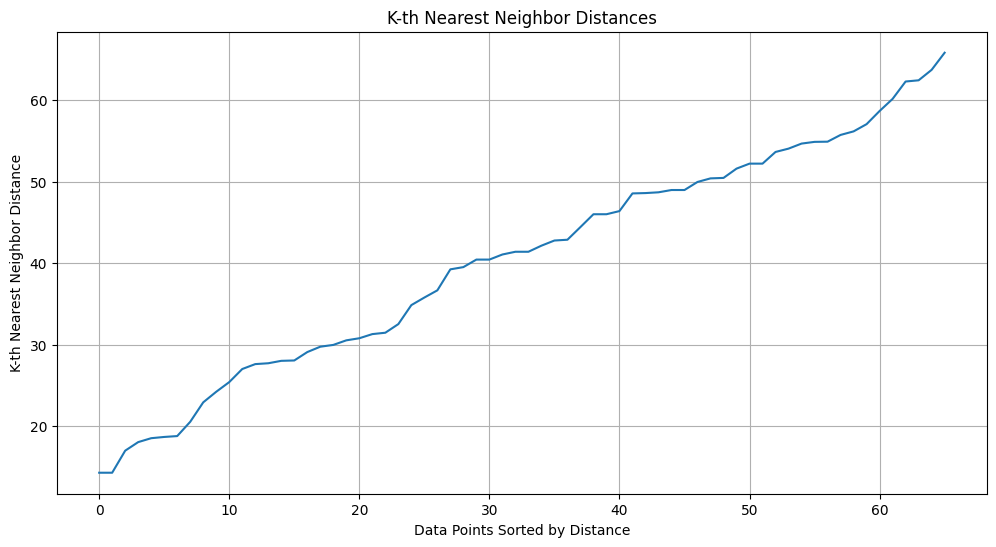

In [3]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances, axis=0)[:, 1]
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title("K-th Nearest Neighbor Distances")
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel("K-th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(df)

In [5]:
cosine_sim_matrix.max(), cosine_sim_matrix.min()

(1.0000105, 0.0)

In [6]:
cosine_sim_matrix = np.clip(cosine_sim_matrix, 0, 1)

In [7]:
cosine_sim_matrix.max(), cosine_sim_matrix.min()

(1.0, 0.0)

In [8]:
cosine_dist_matrix = 1 - cosine_sim_matrix
cosine_dist_matrix.max(), cosine_dist_matrix.min()

(1.0, 0.0)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(cosine_dist_matrix).astype(np.float64)
data_scaled.max(), data_scaled.min()

(1.4785226583480835, -7.62392520904541)

In [11]:
data_scaled = data_scaled + abs(data_scaled.min())
data_scaled.max(), data_scaled.min()

(9.102447867393494, 0.0)

In [13]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    cluster_selection_epsilon=0.0,
    metric='precomputed',
    cluster_selection_method='leaf',
    alpha=0.1
)
clusters = clusterer.fit_predict(data_scaled)
clusters_df = pd.DataFrame(clusters, columns=['Cluster'], index=df.index)

In [ ]:
# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=7, min_samples=1)
# clusters = dbscan.fit_predict(data_scaled)
# clusters_df = pd.DataFrame(clusters, columns=['Cluster'], index=df.index)

In [14]:
pd.DataFrame(clusters, columns=['Cluster'])['Cluster'].value_counts()

Cluster
-1     20
 11    11
 7      8
 10     4
 6      4
 9      3
 1      3
 4      3
 0      2
 8      2
 3      2
 2      2
 5      2
Name: count, dtype: int64

In [ ]:
import pandas as pd
import plotly.express as px

# Create a sample DataFrame
data = {
    'Feature1': [10, 20, 30, 40, 50],
    'Feature2': [15, 25, 35, 45, 55]
}
df = pd.DataFrame(data)

# Add the DataFrame index as a column for hover data
df['Index'] = df.index

fig = px.scatter(df, x='Feature1', y='Feature2',
                 hover_data=['Index'],
                 title='Interactive Plot with Index on Hover')

# Update layout for better readability
fig.update_layout(
    xaxis_title='Feature 1',
    yaxis_title='Feature 2',
    legend_title='Data Points'
)

# Show the plot
fig.show()

In [17]:
import plotly.express as px

fig = px.scatter(x=data_scaled[:, 0], y=data_scaled[:, 1],
                 color=clusters,
                 hover_data=clusters_df.index)

fig.update_layout(title='DBSCAN Clustering with Interactive Labels',
                  xaxis_title='Feature 1',
                  yaxis_title='Feature 2',
                  legend_title='Cluster')

fig.show()
fig = px.scatter(df, x='Feature1', y='Feature2',
                 hover_data=['Index'],
                 title='Interactive Plot with Index on Hover')

# Update layout for better readability
fig.update_layout(
    xaxis_title='Feature 1',
    yaxis_title='Feature 2',
    legend_title='Data Points'
)

# Show the plot
fig.show()

ValueError: String or int arguments are only possible when a DataFrame or an array is provided in the `data_frame` argument. No DataFrame was provided, but argument 'hover_data_0' is of type str or int.

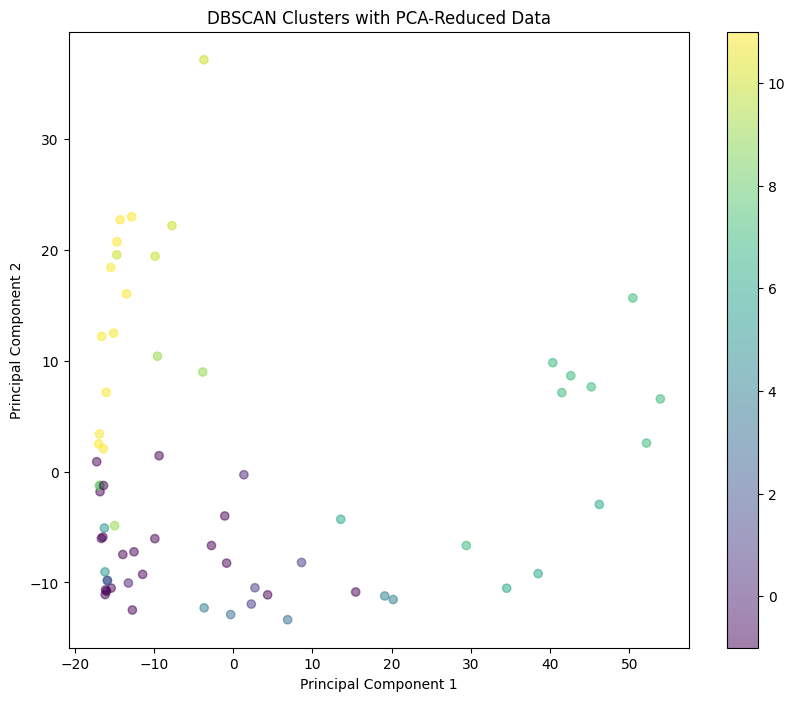

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clusters with PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

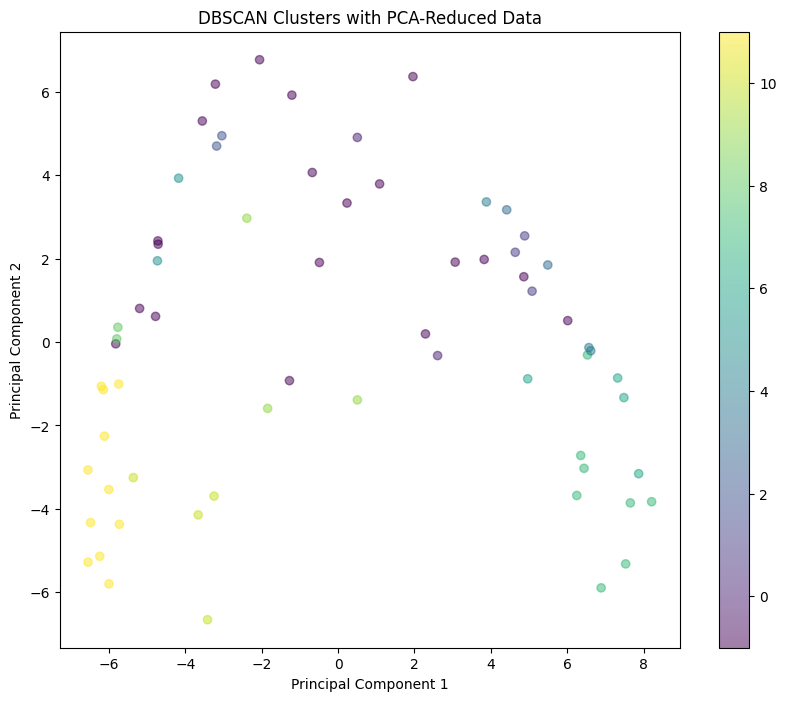

In [16]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clusters with PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()